<a href="https://colab.research.google.com/github/WolfgangUser/Digit_Predict/blob/main/Digit_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [7]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Digit - 1


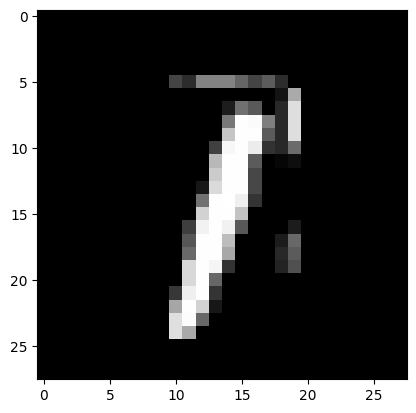

In [9]:
plt.imshow(X_train[67], cmap='grey')
print(f'Digit - {y_train[67]}')

In [10]:
%pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 1.6 MB/s eta 0:00:00


In [11]:
import keras_tuner as kt

In [42]:
def build_digit_predict_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer((28, 28)))
  model.add(tf.keras.layers.Flatten())

  hp_layers = hp.Int('layers', min_value=2, max_value=4, step=1)
  hp_units = hp.Int('units', min_value=128, max_value=512, step=128)
  hp_activations = hp.Choice('activation', ['relu', 'tanh'])

  for i in range(hp_layers):
    model.add(tf.keras.layers.Dense(units=hp_units, activation=hp_activations))

  model.add(tf.keras.layers.Dense(10))
  hp_learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001])

  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [44]:
tuner = kt.Hyperband(
    build_digit_predict_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='proj_dir',
    project_name='mnist'
)

Reloading Tuner from proj_dir/mnist/tuner0.json


In [46]:
tuner.search(X_train, y_train, epochs=50, batch_size=32,
             steps_per_epoch=200, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [47]:
print(best_hps.get('layers'))
print(best_hps.get('units'))
print(best_hps.get('activation'))
print(best_hps.get('learning_rate'))
# 3
# 256
# relu
# 0.001

3
256
relu
0.001


In [69]:
inputs = tf.keras.Input((28, 28))
flat = tf.keras.layers.Flatten()(inputs)
hidden_1 = tf.keras.layers.Dense(256, activation='relu')(flat)
hidden_2 = tf.keras.layers.Dense(256, activation='relu')(hidden_1)
hidden_3 = tf.keras.layers.Dense(256, activation='relu')(hidden_2)
outputs = tf.keras.layers.Dense(10)(hidden_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [70]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy]
)

In [71]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [72]:
!rm -rf ./logs/

In [73]:
tensorboard_callback = tf.keras.callbacks.TensorBoard('./logs/', histogram_freq=1)

In [74]:
history = model.fit(X_train, y_train, batch_size=32, steps_per_epoch=200,
                    verbose=1, validation_steps=50, validation_split=0.2,
                    callbacks=[tensorboard_callback])

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 10.8641 - sparse_categorical_accuracy: 0.6859 - val_loss: 1.3520 - val_sparse_categorical_accuracy: 0.8625


In [75]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4120 - sparse_categorical_accuracy: 0.8549


[1.1791787147521973, 0.8744000196456909]

In [76]:
y_pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [77]:
print(y_test[67])
print(y_pred[67])

4
[ 7.240191  -1.5668968 13.53159   -5.965716  56.175545  -8.109246
 16.94651   -0.5017828 -1.0199679 21.655268 ]


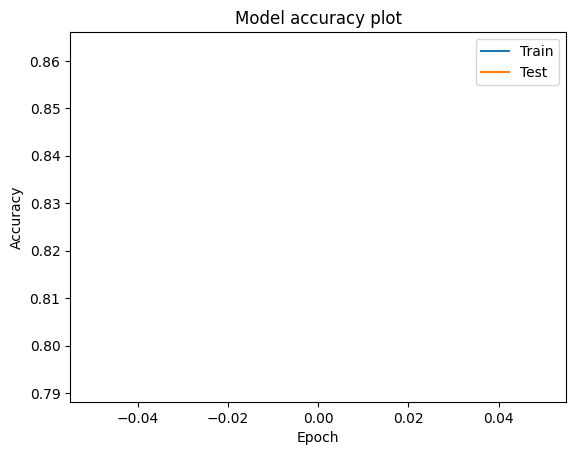

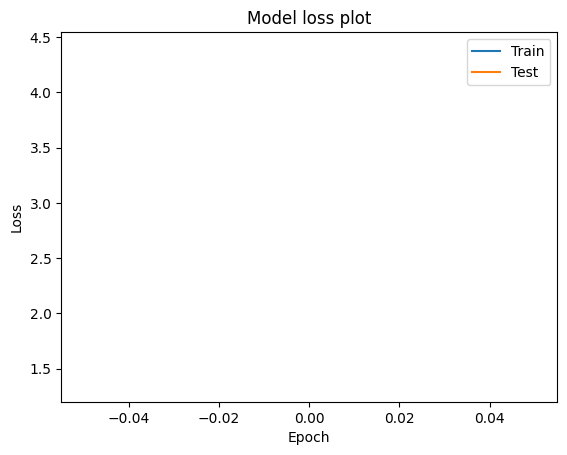

In [78]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

#график потерь модели
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()